In [1]:
from sklearn import metrics
import numpy as np
import scanpy as sc
from matplotlib import pyplot as plt 

from numpy.random import default_rng
rng = default_rng(seed=1234)

In [4]:

# load the python AnnData object
anndata = sc.read_h5ad("/home/julian/Uni/MasterThesis/data/simdata_v3_TS0.9_SS0.1.h5ad")
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/germ_sce.h5ad")
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/acinar_sce.h5ad")
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/COVAC_POSTQC.h5ad")


**Simulated data is already preprocessed**

<BarContainer object of 7 artists>

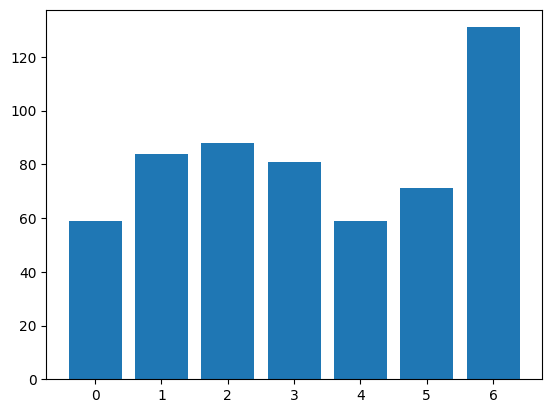

In [5]:
dat = np.unique(anndata.obs.Ordinal_Time_Labels, return_counts=True)
plt.bar(dat[0], dat[1])

## Run Pypsupertime

In [3]:
from pypsupertime import Psupertime

estimator_params = {"early_stopping": False, "max_iter": 100, "track_scores": True}
preprocessing_params = {"log": False, "normalize": False, "scale": False, "smooth": False, "select_genes": "all"}
psuper = Psupertime(estimator_params=estimator_params,
                    n_jobs=4,
                    n_batches=1,
                    random_state=2524)

adata = psuper.run("/home/julian/Uni/MasterThesis/data/simdata_v3_TS0.9_SS0.1.h5ad", "Ordinal_Time_Labels")

Input Data: n_genes=9904, n_cells=573
Preprocessing: done. mode='all', n_genes=9904, n_cells=573
Grid Search CV: CPUs=4, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.406632.02, n_genes=11
Total elapsed time:  0:40:06.239216


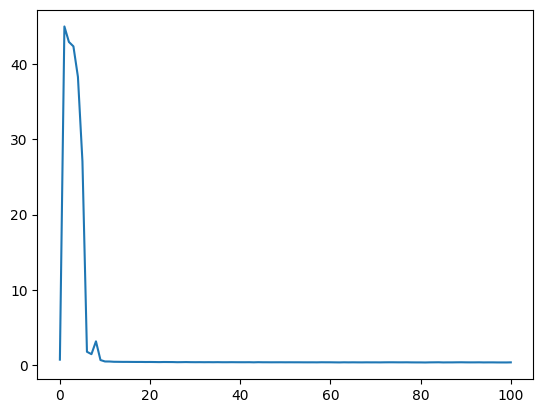

In [12]:
from matplotlib import pyplot as plt

plt.plot(psuper.model.train_losses_)


Best idx: 21 Best Score: 0.4518993135011441 Best Lambda: 0.00701703828670383 Scores std: 0.08321813747143425
1SE idx: 16 1SE Score: 0.39964912280701753 1SE Lambda: 0.022854638641349907


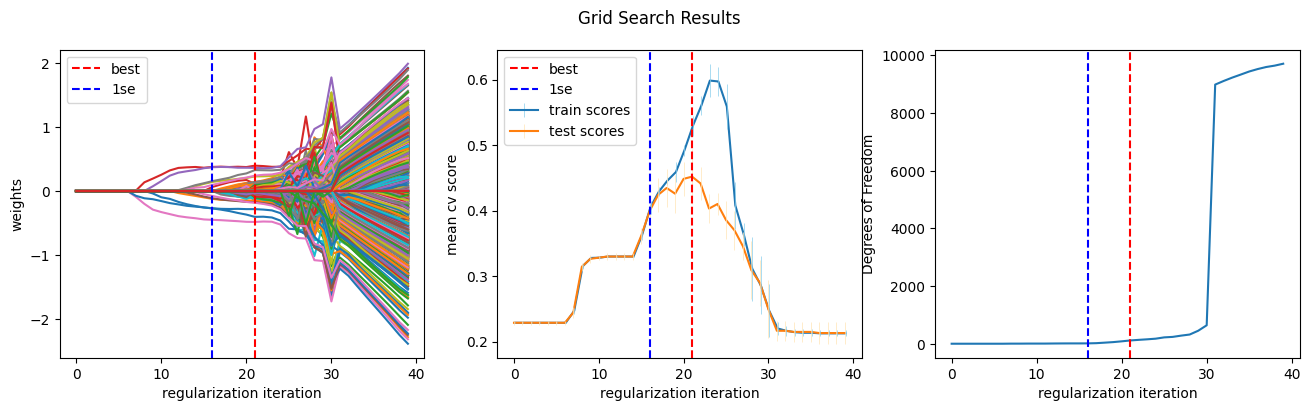

In [5]:
_ = psuper.plot_grid_search()

In [39]:
from masterthesis.model_selection import RegularizationGridSearch
from masterthesis.model import VanillaSGDBinarizedModel
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer, log_loss

#reg_params = np.geomspace(1, 500, 20)
reg_params = np.geomspace(0.25, 0.01, 20) # strict regularization, training on all genes
weights_train = calculate_weights(y_train)
scoring = make_scorer(accuracy_score)
#scoring = make_scorer(balanced_accuracy_score)
fit_params = {"sample_weight": weights_train}
estimator_params = {"early_stopping": True, "max_iter": 10, "random_state": 2524} #"learning_rate": "constant"}

sgd = RegularizationGridSearch(estimator=VanillaSGDBinarizedModel, n_folds=5, n_jobs=4, lambdas=reg_params, scoring=scoring)
sgd.fit(X_train, y_train, estimator_params=estimator_params)

Best idx: 0 Best Score: 0.229126213592233 Best Lambda: 0.25 Scores std: 0.026191828433854238
1SE idx: 0 1SE Score: 0.229126213592233 1SE Lambda: 0.25


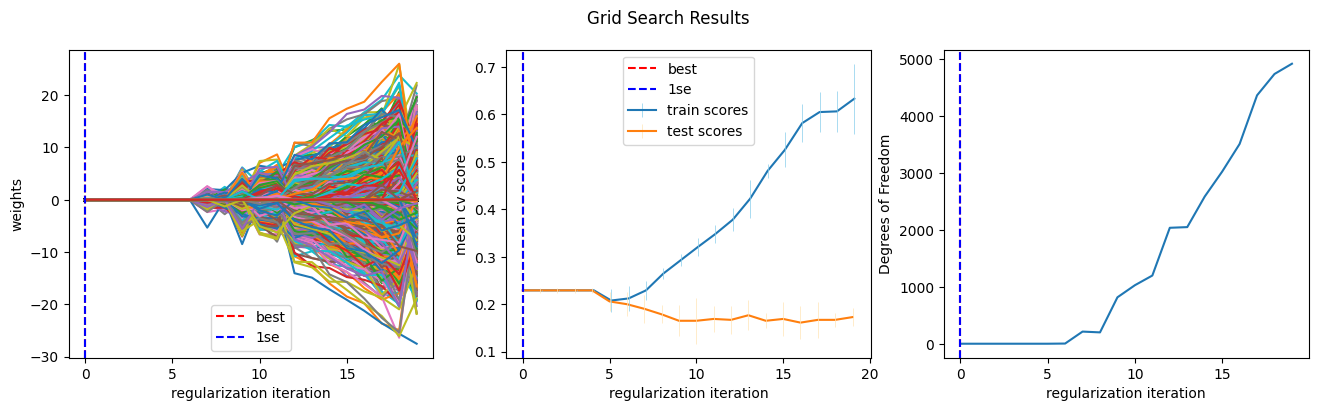

In [35]:
from masterthesis.plots import plot_grid_search
_ = plot_grid_search(sgd)

In [36]:
sparse_model = sgd.get_optimal_model("1se")
sparse_model.fit(X_train, y_train)

VanillaSGDBinarizedModel(max_iter=10, random_state=769, regularization=0.25)

Degrees of freedom 0
Train:
Accuracy: 0.229126213592233
Balanced accuracy: 0.14285714285714285
Mean absolute delta: 3.0
Test:
Accuracy: 0.22413793103448276
Balanced accuracy: 0.14285714285714285
Mean absolute delta: 3.0000000000000004


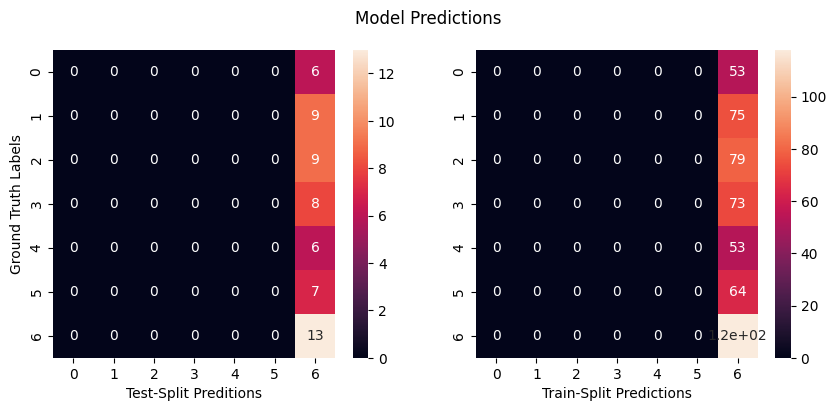

In [37]:
from masterthesis.plots import plot_model_perf
_ = plot_model_perf(sparse_model, test=(X_test, y_test), train=(X_train, y_train))

In [30]:
sparse_model.predict_psuper(anndata)
anndata.var["psupertime_weights"] = sparse_model.coef_

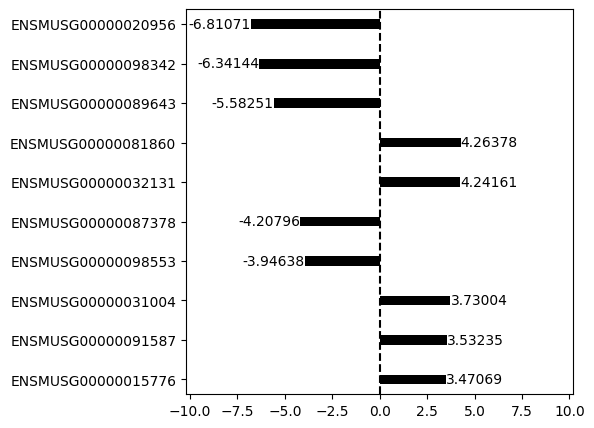

In [31]:
from masterthesis.plots import plot_identified_gene_coefficients

_ = plot_identified_gene_coefficients(sparse_model, anndata, n_top=10, figsize=(5,5))

# Plot labels over psupertime

In [32]:
print(sparse_model.intercept_)
print(sparse_model.binary_estimator_.intercept_)

[6.30829753 5.89684507 5.89684507 5.89684507 5.89684507 5.89684507]
[5.89684507]


/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.11/site-packages/masterthesis/plots.py:135: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=anndata.obs, x='psupertime', fill=label_key, hue=label_key, alpha=0.5,
/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.11/site-packages/masterthesis/plots.py:135: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=anndata.obs, x='psupertime', fill=label_key, hue=label_key, alpha=0.5,
/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.11/site-packages/masterthesis/plots.py:135: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=anndata.obs, x='psupertime', fill=label_key, hue=label_key, alpha=0.5,
/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/py

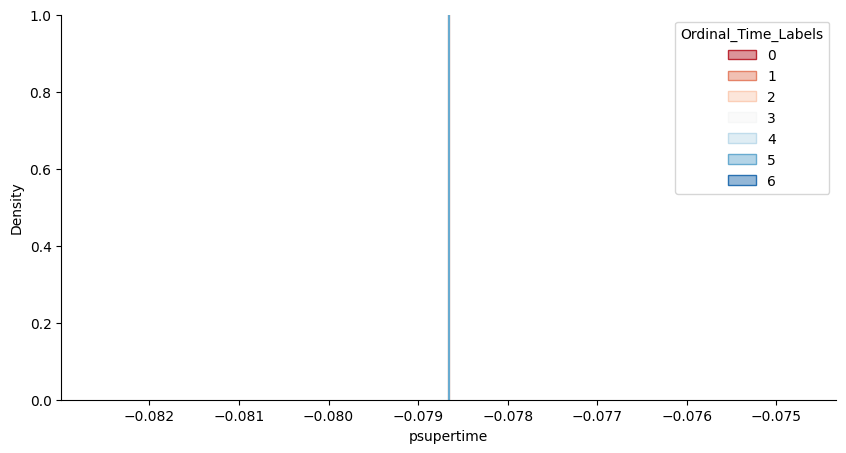

In [31]:
from masterthesis.plots import plot_labels_over_psupertime

_ = plot_labels_over_psupertime(sparse_model, anndata, "Ordinal_Time_Labels")


# Correlation with true latent time

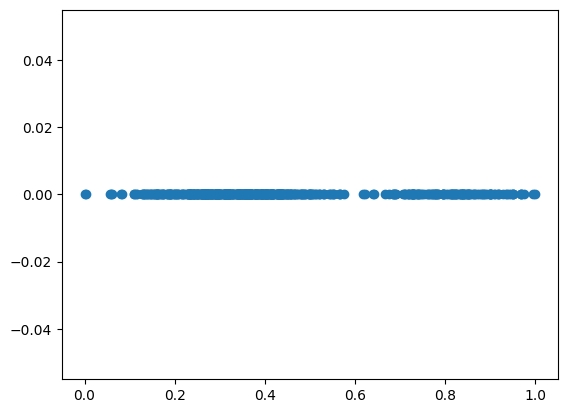

In [25]:
plt.scatter(anndata.obs.Latent_Time, anndata.obs.psupertime)

In [26]:
pearsonr = anndata.obs.Latent_Time.corr(anndata.obs.psupertime)
spearmanr = anndata.obs.Latent_Time.corr(anndata.obs.psupertime, method='spearman')
kendalltau = anndata.obs.Latent_Time.corr(anndata.obs.psupertime, method='kendall')
print("Pearson's correlation:", pearsonr)
print("Spearman's correlation:", spearmanr)
print("Kenall Tau:", kendalltau)

Pearson's correlation: nan
Spearman's correlation: nan
Kenall Tau: nan


/home/julian/.local/share/virtualenvs/code-tW9RC7Ez/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
